# Motion Planning Exercise: Model Predictive Controller

Thao Dang, Kim Wabersich Hochschule Esslingen

In this assignment you will implement and test a model predictive controller for path following and obstacle avoidance using CasADi (https://web.casadi.org). 

The assignment focuses on a basic usage of the optimization library CasADi and its application to model predictive control/motion planning. Note that other libraries exist and may even have better performance. The API to most of these libraries is rather similar to what is shown here. 

To install CasADi on Colab or on your machine, run (remember to use venv or conda on your local machine):

In [13]:
!pip install casadi

You should consider upgrading via the 'C:\Users\wbrad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [14]:
import numpy as np
from scipy.integrate import odeint
import casadi

import matplotlib.pyplot as plt
from matplotlib import animation, rc, cm
from IPython.display import HTML

## Exercise 1.1: Getting started with CasADi

To get to know CasADi, run the solver for a nonlinear optimization problem with constraints:

Minimize the following objective with respect to $(x,y)$: 
$$(y-x^2)^2$$
subject to 
$$ x^2+y^2=1 $$
and
$$ x+y >= 1 $$

CasADi is a symbolic framework for nonlinear optimization and algorithmic differentiation.
The code to solve this problem is given below. 

Understand the optimization problem and the given code example.

In [15]:
def sampleOptimizationProblem():
    opti = casadi.Opti()

    x = opti.variable()
    y = opti.variable()

    opti.minimize(  (y-x**2)**2   )
    opti.subject_to( x**2+y**2==1 )
    opti.subject_to(       x+y>=1 )

    opti.solver('ipopt')

    sol = opti.solve()
    
    return sol.value(x), sol.value(y)


x, y = sampleOptimizationProblem()
print('\nSolution x:', x)
print('Solution y:', y)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

## Exercise 1.2: Visualize objective function and solution

Draw the objective function as 
* a 3d surface plot: https://matplotlib.org/stable/gallery/mplot3d/surface3d.html
* and in a separate plot as a 2d contour plot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html

Plot the solution of the solver in the 2d plot and check if this result makes sense.

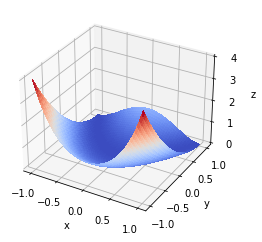

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

## INSERT CODE HERE Exercise 1.2
X = np.linspace(-1, 1, 100)
Y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(X, Y)
Z = (Y-X**2)**2

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()
##

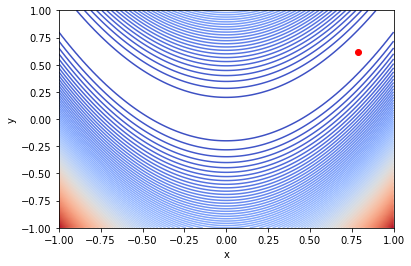

In [17]:
plt.figure()

## INSERT CODE HERE Exercise 1.2
plt.contour(X, Y, Z, 100, cmap=cm.coolwarm)
plt.plot(x, y, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



##
# the solution should be on the unit circle, in the northeast part of the x-y-plane,
# and in the "valley" of the objective function.

## Exercise 1.3: Parametric Optimization Problem

$$(y-x^2)^2$$
subject to 
$$ x^2+py^2=1 $$
and
$$ x+y >= 1 $$
with
$$ p \in [-1,0]$$
* Add the parameter p to the optimization problem below
* Plot the optimium for different parameter values of p

In [18]:
def sampleParametricOptimizationProblem():
    opti = casadi.Opti()

    x = opti.variable()
    y = opti.variable()
    p = opti.parameter()
    p_values = np.arange(-1, 0, 0.05)
    objective_values = np.zeros_like(p_values)
    ## INSERT CODE HERE Exercise 1.3, Hint: use opti.set_value(p, value) to set parameter value
    objective = (y-x**2)**2
    opti.minimize(  objective   )
    opti.subject_to( x**2+p*y**2==1 )
    opti.subject_to(       x+y>=1 )
    opti.solver('ipopt')
    for i in range(len(p_values)):
        opti.set_value(p, p_values[i])
        sol = opti.solve()
        objective_values[i] = sol.value(objective)
        
    
    ##
    return p_values, objective_values

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Text(0, 0.5, 'objective')

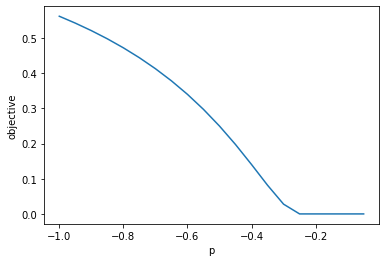

In [19]:
p_values, objective_values = sampleParametricOptimizationProblem()
plt.figure()
plt.plot(p_values,objective_values)
plt.xlabel('p')
plt.ylabel('objective')

## Exercise 2.1: Preparation

The following three cells
* load the reference track
* define the simulation model
* implement the reference generation for a given vehicle state

You need to complete the missing code in for the reference trajectory generation

### Load reference course

['x', 'y', 'yaw', 'curvature', 's']


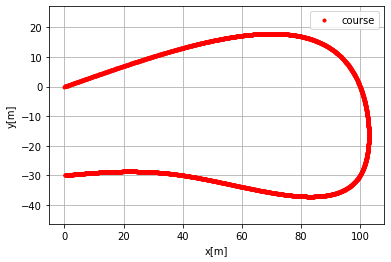

In [20]:
trkdata = np.load('coursedata.npz')
print(trkdata.files)

plt.plot(trkdata['x'], trkdata['y'], ".r", label="course")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

### Functions for simulating our vehicle

* Should be familiar. If not the case, let me know.

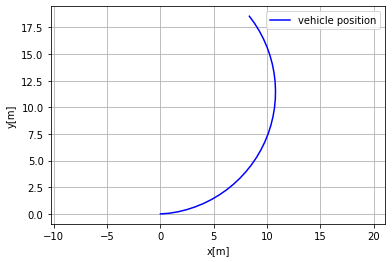

In [21]:
dT = 0.1  # [s] time difference
L = 2.9  # [m] Wheel base of vehicle
veh_dim_x, veh_dim_y = 4, 1.9  # [m] size of vehicle (length, width)
max_steer = np.radians(30.0)  # [rad] max steering angle
max_ax = 2 # [m/ss] max (positive) acceleration
min_ax = -10 # [m/ss] max decceleration (=min negative acceleration)
v_desired = 30/3.6 # the speed at which we want to travel
min_v = 0
max_v = 100/3.6

# sluggish vehicle (only needed for optional excercise):
m = 1800 # [kg] mass
J = 3000 # moment of inertia [kg/m2]
lv = 1.3 # distance COG to front axle [m]
lh = 1.6 # distance COG to rear axle [m]
cav= 2*60000 # lateral tire stiffness front [N/rad]
cah = 2*60000 # lateral tire stiffness rear [N/rad]


def get_circle(x, y, size):  
    """Get points on circle of radius size and center pos (x,y). 
    """
    deg = list(range(0, 360, 5))
    deg.append(0)
    xl = [x + size * np.cos(np.deg2rad(d)) for d in deg]
    yl = [y + size * np.sin(np.deg2rad(d)) for d in deg]
    return xl, yl


def plot_circle(x, y, size, color='-b'):  
    """Draw circle of radius size and center pos (x,y). 
    """
    xl, yl = get_circle(x, y, size)
    plt.plot(xl, yl, color)

    
def normalize_angle(angle):
    """ Normalize an angle to [-pi, pi]. """
    return (angle + np.pi) % (2 * np.pi) - np.pi


class State():
    """
    Class representing the state of a vehicle.

    :var t: (float) current time
    :var x: (float) x-coordinate
    :var y: (float) y-coordinate
    :var yaw: (float) yaw angle
    :var v: (float) speed
    :var beta: (float) slip angle
    :var dyaw_dt: (float) time derivative of slip angle
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0, t=0.0):
        """Instantiate the object."""
        super(State, self).__init__()
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.t = t
        self.beta = 0
        self.dyaw_dt = 0
    
    def dynamic_model(self, state, t, acceleration, delta): 
        """Model for the lateral and yaw dynamics of the bicylce model.
        
        This function is to be used in odeint and has 
        form "dstate_dt = f(state,t)". 
        """
        x, y, yaw, v, beta, dyaw_dt = state
        
        dbeta_dt = - (cav+cah)/(m*v)*beta - (1+(cav*lv-cah*lh)/(m*v**2))*dyaw_dt + cav/(m*v)*delta
        ddyaw_dt2 = - (cav*lv-cah*lh)/J*beta - (cav*lv**2+cah*lh**2)/(J*v)*dyaw_dt + cav*lv/J*delta

        dx_dt = v*np.cos(yaw+beta)
        dy_dt = v*np.sin(yaw+beta)
        dyaw_dt = dyaw_dt
        dv_dt = acceleration
        
        dstate_dt = [dx_dt, dy_dt, dyaw_dt, dv_dt, dbeta_dt, ddyaw_dt2]
        return dstate_dt
        
    def update(self, acceleration, delta):
        """
        Update the state of the vehicle.
        
        :param acceleration: (float) Acceleration
        :param delta: (float) Steering
        """
        delta = np.clip(delta, -max_steer, max_steer)
        acceleration = np.clip(acceleration, min_ax, max_ax)
        
        state0 = [self.x, self.y, self.yaw, self.v, self.beta, self.dyaw_dt]
        ti = [self.t, self.t+dT]
        sol = odeint(self.dynamic_model, state0, ti, args=(acceleration, delta))

        self.x, self.y, self.yaw, self.v, self.beta, self.dyaw_dt = sol[1]
        self.yaw = normalize_angle(self.yaw)
        self.beta = normalize_angle(self.beta)
        self.t = ti[1]


# demonstrate simple motion
S = State(v=v_desired)
x, y = [S.x], [S.y]
for i in range(30):
    S.update(acceleration=0, delta=np.radians(15.0))
    x.append(S.x)
    y.append(S.y)
    
plt.plot(x, y, "b", label="vehicle position")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

### Functions for getting closest point on reference course and sampling a reference trajectory 

The following functions will be used to generate a reference trajectory that our vehicle should follow.
The reference trajectory should be sampled from the course loaded above and should start close to the vehicle's current position.

An example of usage is given at the end of the cell below.

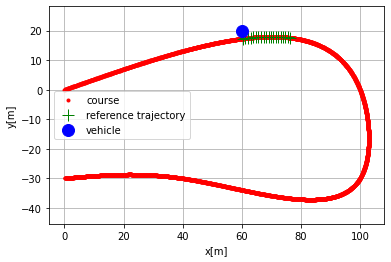

In [22]:
def calc_target_index(state, cx, cy, cyaw):
    """
    Compute index of closest point in reference trajectory to current position.

    :param state: (State object)
    :param cx: [m] x-coordinates of (sampled) course
    :param cy: [m] y-coordinates of (sampled) course
    :param cyaw: [rad] tangent angle of (sampled) course
    :return: (int, float) 
    """
    # Calc ref point position
    fx = state.x 
    fy = state.y 

    # Search nearest point index
    dx_vec = fx - np.asarray(cx).reshape([-1,1]) # col vector
    dy_vec = fy - np.asarray(cy).reshape([-1,1]) # col vector
    dist = np.hstack([dx_vec, dy_vec])
    dist_2 = np.sum(dist**2, axis=1)
    target_idx = np.argmin(dist_2)

    return target_idx


def calc_ref_trajectory(state, cx, cy, cyaw, v_desired=30/3.6, N=10, ds=0.1):
    """
    Compute a reference trajectory starting closest to current state.

    :param state: (State object)
    :param cx: [m] x-coordinates of (sampled) course
    :param cy: [m] y-coordinates of (sampled) course
    :param cyaw: [rad] tangent angle of (sampled) course
    :param ds: [m] arc length betwenn consecutive samples of course
    :param v_desired: [m/s] desired speed of reference trajectory 
    :param N: desired length of reference trajectory snippet
    :return: Nx4 matrix of [x, y, yaw, v_desired; ...]
    """
    start_idx = calc_target_index(state, cx, cy, cyaw)
    refpos = []
    for i in range(N):
        ## INSERT CODE HERE exercise 2.1
        arclen = v_desired * i * dT
        d_idx = arclen // ds
        idx = int(start_idx + d_idx)
        
        ##
        refpos.append((cx[idx], cy[idx], cyaw[idx], v_desired))
    return np.asarray(refpos)


# select a sample vehicle position and compute closest reference trajectory with velocity 30km/h
state = State(x=60.0, y=20.0, yaw=0.0, v=0, t=0.0)
reftraj = calc_ref_trajectory(state, trkdata['x'], trkdata['y'], trkdata['yaw'], 
                              N=20, v_desired=30/3.6)

plt.figure()
plt.plot(trkdata['x'], trkdata['y'], ".r", label="course")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.plot(reftraj[:,0], reftraj[:,1], 'g+', ms=12, label='reference trajectory');
plt.plot(state.x, state.y, 'bo', ms=12, label='vehicle');
plt.legend()
plt.grid(True);


## Exercise 2.2: MPC without obstacles

The following three cells
* define the optimization problem for path tracking,
* provide a function for running the solver, and
* implement the MPC.

You need to add the code for the actual MPC (this will need to call the solver and the simulation model).

In addition, find a good set of weight parameters for the objective function.

In [50]:
# Set up the optimization problem.

# number of look ahead steps
N = 20

# obstacle - TO BE USED IN EXERCISE 2.2/2.3
obstacle = (20, 7, 14)

opti = casadi.Opti()

# system states 
X   = opti.variable(4, N)
x   = X[0,:]
y   = X[1,:]
yaw = X[2,:]
v   = X[3,:]
s   = opti.variable(1, N-1)
opti.subject_to(s[:] >= 0)

n_states = X.shape[0]

# control signals
U              = opti.variable(2, N-1)
acceleration   = U[0,:]
delta          = U[1,:]
n_controls = U.shape[0]

# parameters containing initial states and reference states:
#   P[:,0] is the initial state
#   P[:,1:N+1] define the reference trajectory
P = opti.parameter(n_states, N)

# vehicle kinematics model: dx/dt = f(x,u)
# x=[x,y,yaw,v], u=[acceleration,delta]
f = lambda x_,u_: casadi.vertcat(
    x_[3]*casadi.cos(x_[2]),
    x_[3]*casadi.sin(x_[2]),
    x_[3]*casadi.tan(u_[1])/L,
    u_[0]) 

# state weights matrix - MODIFY HERE Exercise 2.2
Q_x = 1e1
Q_y = 1e1
Q_yaw = 2e2
Q_v = 1e1
Q = casadi.diagcat(Q_x, Q_y, Q_yaw, Q_v)

# controls weights matrix - MODIFY HERE IN Exercise 2.2
R_accel = 1
R_delta = 1
R = casadi.diagcat(R_accel, R_delta)

# initial constraint
opti.subject_to(X[:, 0] == P[:, 0])

# initialize cost
ref_traj_cost = 0

# loop over prediction horizon
for i in range(0,N-1): 
    # INSERT YOUR CODE HERE, Exercise 2.2 
    # Predicted dynamics using Runge-Kutta 4 integration
    k1 = f(X[:, i], U[:, i])
    k2 = f(X[:, i] + dT/2 * k1, U[:, i])
    k3 = f(X[:, i] + dT/2 * k2, U[:, i])
    k4 = f(X[:, i] + dT * k3, U[:, i])
    opti.subject_to(X[:, i+1] == X[:, i] + dT/6 * (k1 + 2*k2 + 2*k3 + k4))
    # State constraints
    #opti.subject_to((x[i+1] - obstacle[0])**2 + (y[i+1]-obstacle[1])**2 >= obstacle[2]**2)
    opti.subject_to((x[i+1]-obstacle[0])**2 + (y[i+1]-obstacle[1])**2 + s[i] > obstacle[2]**2)
    opti.subject_to(v[i+1] >= min_v)
    opti.subject_to(v[i+1] <= max_v)
    # Input constraints
    opti.subject_to(acceleration[i] <= max_ax)
    opti.subject_to(acceleration[i] >= min_ax)
    opti.subject_to(delta[i] <= max_steer)
    opti.subject_to(delta[i] >= -max_steer)
    
    # the reference objective
    x_diff = X[:, i+1] - P[:, i+1]
    x_diff[2] = casadi.asin(casadi.sin(x_diff[2])) # normalize angle difference
    ref_traj_cost += x_diff.T @ Q @ x_diff + U[:,i].T @ R @ U[:,i] + 1000*s[i] # FOR SOFT CONSTRAINED TASK + 1000 * s[i]
    ##
    
# set objective
opti.minimize( ref_traj_cost )

# set solver opts
opti.solver('ipopt', { 'ipopt': { 'print_level': 0 }, 'print_time': 0 })
# use this to have full debug output:
# opti.solver('ipopt')

In [51]:
def mpcStep(opti, x_init, y_init, yaw_init, v_init):
    """
    The solver function for the optimization problem defined above. 
    This should be used in the MPC later.
    """
    # initial values for solver 
    opti.set_initial(x, x_init)
    opti.set_initial(y, y_init)
    opti.set_initial(yaw, yaw_init)
    opti.set_initial(v, v_init)

    opti.set_initial(acceleration, 0)
    opti.set_initial(delta, 0)

    # fill parameters
    state = State(x=x_init, y=y_init, yaw=yaw_init, v=v_init, t=0.0)
    
    refpos = calc_ref_trajectory(state, trkdata['x'], trkdata['y'], trkdata['yaw'], v_desired=30/3.6, N=N)

    p0 = casadi.DM(n_states, N)
    p0[:,0] = casadi.DM([x_init, y_init, yaw_init, v_init])
    for i in range(1,N):
        p0[:,i] = casadi.DM(refpos[i,:])  
    opti.set_value(P, p0)

    # run optimizer
    sol = opti.solve()
    
    # control vector (acceleration, delta)
    control_vec = sol.value(U)[:,0]
    
    # predicted next state (x,y,yaw,v)
    state_vec = sol.value(X)[:,1]
    
    return (control_vec, state_vec)


x_init, y_init, yaw_init, v_init = 0, 0, 0, 30/3.6
control_vec, state_vec = mpcStep(opti, x_init, y_init, yaw_init, v_init)

print('control vec: ', control_vec)
print('predicted state: ', state_vec)

# should be
# control vec:  [2.00000002 0.52359879]
# predicted state:  [0.8393769  0.07062973 0.16789612 8.53333334]

control vec:  [-2.17418749  0.52359879]
predicted state:  [0.81879215 0.06718543 0.163741   8.11591458]


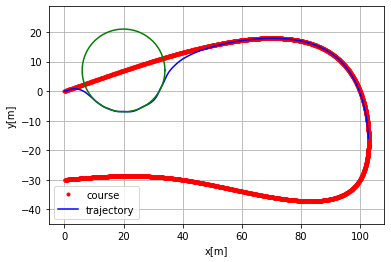

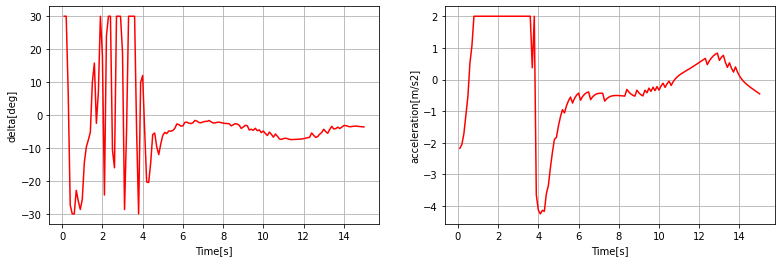

In [52]:
# The actual MPC code.

state = State(x=x_init, y=y_init, yaw=yaw_init, v=v_init, t=0.0)

disp_x = [state.x]
disp_y = [state.y]
disp_v = [state.v]
disp_yaw = [state.yaw]
disp_t = [state.t]
disp_accel = []
disp_delta = []

# main MPC loop:
for i in range(150):
    # MODIFY CODE HERE Exercise 2.2
    control_vec, state_vec = mpcStep(opti, state.x, state.y, state.yaw, state.v)
    disp_accel.append(control_vec[0])
    disp_delta.append(control_vec[1])
    
    # MODIFY CODE HERE Exercise 2.2
    state.update(acceleration= control_vec[0], delta=control_vec[1])
    
    disp_x.append(state.x)
    disp_y.append(state.y)
    disp_v.append(state.v)
    disp_yaw.append(state.yaw)
    disp_t.append(state.t)

# visualization
plt.figure()
plt.plot(trkdata['x'], trkdata['y'], ".r", label="course")
plt.plot(disp_x, disp_y, "-b", label="trajectory")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)
plot_circle(obstacle[0], obstacle[1], obstacle[2], color='-g')

plt.figure(figsize=(13, 4))
plt.subplot(1,2,1)
plt.plot(disp_t[1:], np.asarray(disp_delta)*180/np.pi, "-r")
plt.xlabel("Time[s]")
plt.ylabel("delta[deg]")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(disp_t[1:], disp_accel, "-r")
plt.xlabel("Time[s]")
plt.ylabel("acceleration[m/s2]")
plt.grid(True)

## Exercise 2.3: MPC with obstacles

Modify the code above so that our vehicle evades the circular obstacle at position (20,7) with radius 3:

```
# obstacle
obstacle = (20, 7, 3)
```

## Exercise 2.4: MPC with soft constraints

Soften the obstacle avoidance constraint so that the MPC does not become infeasible for:

```
# obstacle
obstacle = (20, 7, 14)
```

## Animation of your results

The next cells create an animation that demonstrates how the vehicle will drive along the given path.

In [34]:
def getVehicleContours(pos_x, pos_y, yaw):
    """Compute object contours."""

    L_2, W_2 = veh_dim_x/2.0, veh_dim_y/2.0
    u = np.array([
        [0, -W_2, 1],    # 1
        [L_2, -W_2, 1],  # 2
        [L_2, W_2, 1],   # 3
        [0, W_2, 1],     # 4
        [L_2, 0, 1],     # 5
        [0, -W_2, 1],    # 6
        [0, W_2, 1],     # 7
        [-L_2, W_2, 1],  # 8
        [-L_2, -W_2, 1],  # 9
        [0, -W_2, 1]     # 10
    ]).T

    T = np.array([
        [np.cos(yaw), -np.sin(yaw), pos_x],
        [np.sin(yaw), np.cos(yaw), pos_y]
    ])

    v = np.dot(T, u)
    return v[0, :], v[1, :]

In [53]:
# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots(figsize=(8,8))
plt.close()
ax.axis("equal")
ax.grid(True)
ax.set_xlim((-10, 110))
ax.set_ylim((-60, 60))
course, = ax.plot([], [], "r.", label="course")
trajectory, = ax.plot([], [], "-b", label="trajectory")
vehicle, = ax.plot([], [], "b", label="vehicle")
title_text = ax.text(.7, .9, '', transform = ax.transAxes)
obs, = ax.plot([], [], "-g", label="obstacle")

# initialization function: plot the background of each frame
def init():
    course.set_data(trkdata['x'], trkdata['y'])
    xl, yl = get_circle(obstacle[0], obstacle[1], obstacle[2])
    obs.set_data(xl, yl)
    return (course,obs,)
  
# animation function: this is called sequentially
def animate(i):
    trajectory.set_data(disp_x[:i], disp_y[:i])
    px, py = getVehicleContours(disp_x[i], disp_y[i], disp_yaw[i])
    vehicle.set_data(px, py)
    title_text.set_text(("Speed[km/h]:" + str(disp_v[i] * 3.6)[:4]))
    return (trajectory, vehicle, title_text, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(disp_x), 
                               interval=50, blit=True)

rc('animation', html='jshtml')
anim